#SteamVis

Welcome to my Steam game visualization notebook! This notebook loads the data collected as output from GetGameData, cleans it, and visualizes it.

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import datetime
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import time

In [2]:
with open('game_data.json', 'r') as f:
    game_dict = json.load(f);

From the game dictionary, collect all of the unique tags.

In [3]:
all_tags = [];
for appnumber in game_dict:
    for tag in game_dict[appnumber]['tags']:
        heading = 'tag_%s' % tag;
        if heading not in all_tags:
            all_tags.append(heading);

all_tags = sorted(all_tags)
#print len(all_tags)
#print all_tags

Reformat the game dictionary into a list of dictionaries in a pandas dataframe friendly way. Specfically, change the appnumber to an integer, format the release date as a pandas <code>Timestamp</code> object, and unpack the tags list into individual dictionary entries. For the tag entries, the tag is the key and the position in the original list (with 1 added so the first tag is rank 1) is the value.

In [4]:
game_dict_list = [];

for appnumber in game_dict:
    game = game_dict[appnumber];
    
    new_dict = {};
    new_dict['appnumber'] = int(appnumber);
    for key in game:
        new_dict[key] = game[key];
    
    new_dict['release_date'] = pd.Timestamp(datetime.date(game['release_year'],
                                                          game['release_month'],
                                                          game['release_day']));
    new_dict.pop('release_year', None);
    new_dict.pop('release_month', None);
    new_dict.pop('release_day', None);
    
    for rank, tag in enumerate(game['tags']):
        new_dict['tag_%s' % tag] = rank + 1;
    new_dict.pop('tags', None);
    
    game_dict_list.append(new_dict);

The list of dicitonaries is converted directly into a dataframe.

In [5]:
game_df = pd.DataFrame(game_dict_list);
game_df.head()

,appnumber,game_name,good_review_percentage,good_review_percentage_recent,lifetime,metascore,n_reviews,n_reviews_recent,platform_linux,platform_mac,...,tag_Warhammer 40K,tag_Web Publishing,tag_Werewolves,tag_Western,tag_Word Game,tag_World War I,tag_World War II,tag_Wrestling,tag_Zombies,tag_e-sports
0,221540,DG2: Defense Grid 2,81,85,824,81,1644,34,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,377220,Deficis,-1,-1,513,-1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,287140,Selfie : Sisters of the Amniotic Lens,78,-1,597,-1,76,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,377120,Chronicle Keepers: The Dreaming Garden,72,-1,563,-1,29,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,541130,PARADOX,100,-1,48,-1,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, convert all of the missing tag entries into a value of 0.

In [6]:
game_df[all_tags] = game_df[all_tags].fillna(0);
game_df.head()

,appnumber,game_name,good_review_percentage,good_review_percentage_recent,lifetime,metascore,n_reviews,n_reviews_recent,platform_linux,platform_mac,...,tag_Warhammer 40K,tag_Web Publishing,tag_Werewolves,tag_Western,tag_Word Game,tag_World War I,tag_World War II,tag_Wrestling,tag_Zombies,tag_e-sports
0,221540,DG2: Defense Grid 2,81,85,824,81,1644,34,1,1,...,0,0,0,0,0,0,0,0,0,0
1,377220,Deficis,-1,-1,513,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,287140,Selfie : Sisters of the Amniotic Lens,78,-1,597,-1,76,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,377120,Chronicle Keepers: The Dreaming Garden,72,-1,563,-1,29,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,541130,PARADOX,100,-1,48,-1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Removes duplicate games: First, the dataframe is sorted by appnumber so that the lowest appnumber appears first. The dataframe is then grouped by the game name, and the original dataframe is replaced taking only the first entry from each game name. Finally, the entry with an empty game name is dropped, and the index of the dataframe is reset.

In [7]:
game_df.sort('appnumber', ascending=True, inplace=True);
same_games = game_df.groupby('game_name');
game_df = same_games.first().drop('').reset_index();
game_df.head()

,game_name,appnumber,good_review_percentage,good_review_percentage_recent,lifetime,metascore,n_reviews,n_reviews_recent,platform_linux,platform_mac,...,tag_Warhammer 40K,tag_Web Publishing,tag_Werewolves,tag_Western,tag_Word Game,tag_World War I,tag_World War II,tag_Wrestling,tag_Zombies,tag_e-sports
0,Fieldrunners 2,215710,85,-1,1445,73,263,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,! That Bastard Is Trying To Steal Our Gold !,449940,61,-1,300,-1,13,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"""BUTTS: The VR Experience""",439260,73,-1,326,-1,42,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"""Glow Ball"" - The billiard puzzle game",388390,14,-1,1043,-1,28,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,#SelfieTennis,392190,68,-1,268,-1,63,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Find and plot the tags that appear most often.

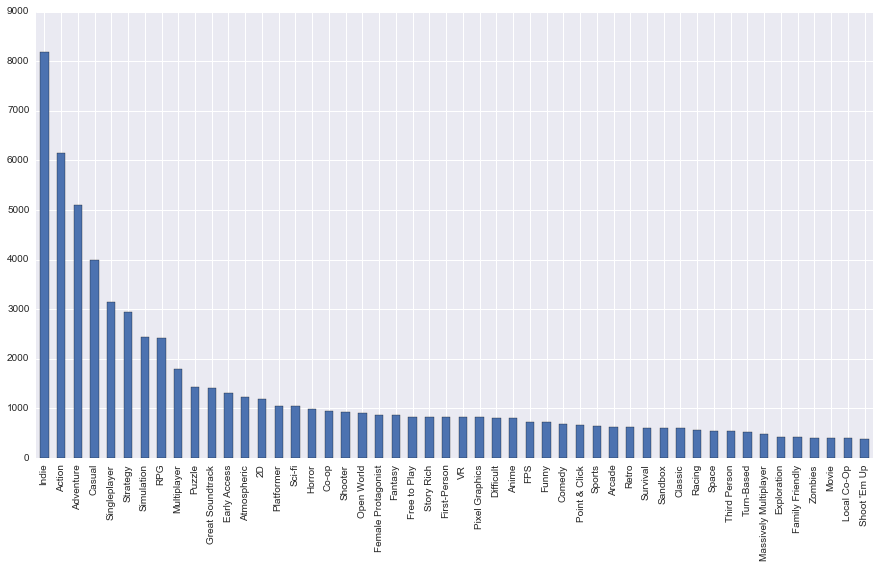

In [8]:
tag_counts = (game_df[all_tags] > 0).sum();
tag_counts.sort(ascending=False, inplace=True);
bar_lefts = range(len(all_tags));
tag_labels = [tag[4:] for tag in tag_counts.index];

max_tags = 50;
fig_counts = plt.figure(figsize=(15,8));
ax = tag_counts[:max_tags].plot(kind='bar');
ax.set_xticklabels(tag_labels[:max_tags]);

Define functions to help in making masks:

<code>tag_not</code> removes games that match <code>tag</code>.

<code>tag_most_like</code> finds games that match <code>tag</code> as one of the first <code>rank</code> tags.

<code>tag_most_unlike</code> removes games that match <code>tag</code> as one of the first <code>rank</code> tags.

<code>tag_is_but_unlike</code> finds games that match <code>tag</code>, but not as one of the first <code>rank</code> tags.

<code>tag_is_between</code> finds games that match <code>tag</code> between <code>ranklow</code> and <code>rankhigh</code>, inclusive.

The tag can be input as the original tag format, or in the dataframe format with <code>tag_</code> as the prefix.

In [9]:
def tag_not(df, tag):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return df[heading] == 0;
    
    return df[tag] == 0;

In [10]:
def tag_most_like(df, tag, rank = 5):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return ((df[heading] <= rank) & ~tag_not(df, heading));
    
    return ((df[tag] <= rank) & ~tag_not(df, tag));

In [11]:
def tag_most_unlike(df, tag, rank = 5):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return ((df[heading] >= rank) | tag_not(df, heading));
    
    return ((df[tag] >= rank) | tag_not(df, tag));

In [12]:
def tag_is_but_unlike(df, tag, rank = 5):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return (df[heading] >= rank);
    
    return (df[tag] >= rank);

In [13]:
def tag_is_between(df, tag, rankhigh = 5, ranklow = 10):
    if tag not in df.columns:
        heading = 'tag_%s' % tag;
        
        if heading not in df.columns:
            print("%s is not a valid tag. Returning all True." % tag);
            return [True] * len(df.index);
        
        return ((df[heading] >= rankhigh) & (df[heading] <= ranklow));
    
    return ((df[tag] >= rankhigh) & (df[tag] <= ranklow));

In [14]:
def steamvis(gamedf, mask=[], min_user=-5, min_meta=-5, label_games=False):
    if len(mask) == 0:
        mask = [True]*len(gamedf.index);
    plotdf = gamedf[mask];
    fig = plt.figure(figsize=(10,10));
    plt.scatter(plotdf['good_review_percentage'], plotdf['metascore']);
    plt.xlim(min_user, 105);
    plt.ylim(min_meta, 105);
    plt.xlabel('Positive User Review Percentage');
    plt.ylabel('Metacritic Score');
    
    if label_games:
        for label,x,y in zip(plotdf['game_name'],
                             plotdf['good_review_percentage'],
                             plotdf['metascore']):
            plt.annotate(label, xy=(x,y), xytext=(x+0.25,y+0.25));
    
    #def over_game(event):
    #    xcoord = event.xdata;
    #    ycoord = event.ydata;
    #    print xcoord, ycoord
    #    for label,x,y in zip(plotdf['game_name'],
    #                         plotdf['good_review_percentage'],
    #                         plotdf['metascore']):
    #        if (abs(xcoord-x) < 0.25) and (abs(ycoord-y) < 0.25):
    #            plt.annotate(label, xy=(x,y), xytext=(x+0.25,y+0.25));
    
    #fig.canvas.mpl_connect('motion_notify_event', over_game);

    #def pick_game(event):
    #    ind = event.ind;
    #    print ind, np.take(plotdf['good_review_percentage'], ind), np.take(plotdf['metascore'], ind)
    
    #fig.canvas.mpl_connect('pick_event', pick_game);
    
    plt.show();

In [15]:
def bestgames(gamedf, mask = [], min_user = -1, min_meta = -1, sort_method = 'user'):
    if len(mask) == 0:
        mask = [True]*len(gamedf.index);
    fullmask = mask & ((gamedf['metascore'] >= min_meta) &
                        (game_df['good_review_percentage'] >= min_user));
    printdf = gamedf[fullmask][['appnumber', 'game_name',
                                'good_review_percentage',
                                'metascore']];
    if sort_method == 'user':
        printdf.sort('good_review_percentage', ascending=False, inplace=True);
    elif sort_method == 'meta':
        printdf.sort('metascore', ascending=False, inplace=True);
    elif sort_method == 'avg':
        printdf['avg'] = printdf[['good_review_percentage', 'metascore']].mean(axis=1);
        printdf.sort('avg', ascending=False, inplace=True)
    else:
        print "Unknown sort method. Enter 'user', 'meta', or 'avg'. The default is 'user'.\n";
        printdf.sort('good_review_percentage', ascending=False, inplace=True);
    return printdf;

Basic mask passes 7189 games.
Full mask passes 7189 games.


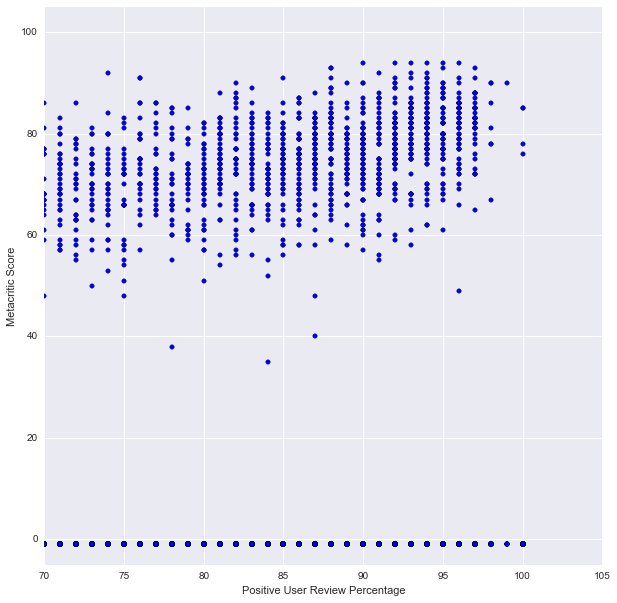

,appnumber,game_name,good_review_percentage,metascore
6146,11920,LUMINES™ Advance Pack,100,-1
1466,504700,Blockships,100,-1
7155,333290,Mos Speedrun 2,100,-1
8585,348430,Quell Reflect,100,-1
11666,504560,The Unwelcomed,100,-1
7136,398250,Moonstrider,100,-1
12726,548330,Wheely,100,-1
1405,554470,BladeShield,100,-1
12730,521580,Where are my Internets?,100,-1
7109,502230,Monsters' Den: Book of Dread,100,-1


In [37]:
basicmask = (tag_not(game_df, "Horror") & tag_not(game_df, "FPS") &
             tag_not(game_df, "Racing") & tag_not(game_df, "Zombies") &
             tag_not(game_df, "Dating Sim") & tag_not(game_df, "Trading Card Game") &
             (game_df['n_reviews'] > 10));
print 'Basic mask passes {0} games.'.format(sum(basicmask))
mask = (basicmask);
print 'Full mask passes {0} games.'.format(sum(mask))
steamvis(game_df, mask, 70, label_games=False)
bestdf = bestgames(game_df, mask, 80, sort_method='user')

pd.options.display.max_rows = 1000
bestdf